In [1]:
import os
from pathlib import Path
import zipfile, kaggle

In [2]:
path = Path('titanic')
if not path.exists(): #downloading from kaggle api
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
df.isna().sum() 
# We note lots of missing values for age and cabin

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace=True) #Filling in missing values with the mode

In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

<Axes: >

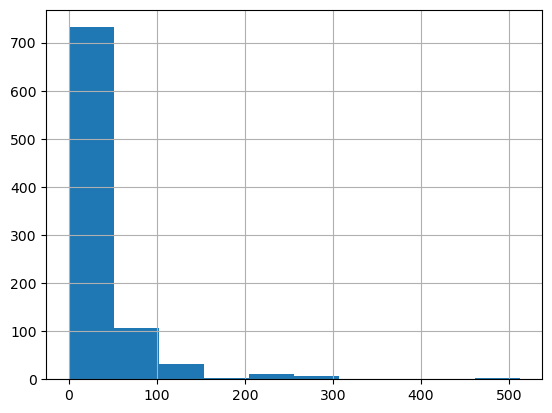

In [9]:
df['Fare'].hist()

In [10]:
#transform hist to prevent long postive skew from affecting results
df['Logfare'] = np.log(df['Fare'] + 1) #prevents 0 values 

<Axes: >

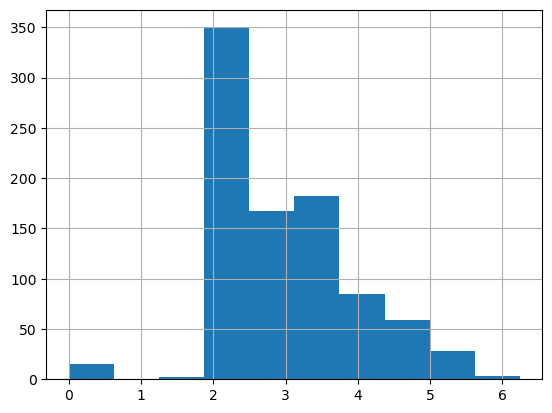

In [11]:
df['Logfare'].hist()

In [12]:
df.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [13]:
df.describe(include = [object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
df = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'], dtype = 'float')
df.columns
#one - hot encoding

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [16]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head(10)

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [17]:
from torch import tensor
t_dep = tensor(df.Survived)

In [18]:
indep_cols = ['Age', 'SibSp', 'Parch', 'Logfare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype = torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [19]:
t_indep.size()

torch.Size([891, 12])

In [20]:
len(t_indep.shape) # Matrix is rank 2 tensor

2

# Linear Model

In [21]:
#Creating random coefficients, 1 coefficient for 1 column. Don't need a constant?
#Re-seed 
torch.manual_seed(17)

n_coeff = t_indep.shape[1]
coeffs = (torch.rand(n_coeff) - 0.5) # Centered around 0
coeffs

tensor([-0.0658,  0.0351,  0.3302, -0.3761, -0.4707,  0.0494, -0.1175,  0.0463, -0.0317, -0.4828, -0.4786, -0.1336])

In [22]:
t_indep * coeffs 

tensor([[-1.4467,  0.0351,  0.0000, -0.7937, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-2.4988,  0.0351,  0.0000, -1.6101, -0.0000,  0.0494, -0.1175,  0.0000, -0.0000, -0.4828, -0.0000, -0.0000],
        [-1.7097,  0.0000,  0.0000, -0.8233, -0.0000,  0.0494, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-2.3016,  0.0351,  0.0000, -1.5011, -0.0000,  0.0494, -0.1175,  0.0000, -0.0000, -0.0000, -0.0000, -0.1336],
        [-2.3016,  0.0000,  0.0000, -0.8285, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-1.5782,  0.0000,  0.0000, -0.8451, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.4786, -0.0000],
        [-3.5510,  0.0000,  0.0000, -1.4924, -0.4707,  0.0000, -0.1175,  0.0000, -0.0000, -0.0000, -0.0000, -0.1336],
        ...,
        [-1.6440,  0.0000,  0.0000, -0.7845, -0.4707,  0.0000, -0.0000,  0.0000, -0.0317, -0.0000, -0.0000, -0.1336],
        [-2.5646,  0.0000,  1.6510, -1.2809

In [23]:
t_indep.shape

torch.Size([891, 12])

In [24]:
vals, indices = t_indep.max(dim=0)
vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [25]:
t_indep = t_indep/vals #scaling by max value

In [26]:
preds = (t_indep*coeffs).sum(axis=1)
preds.shape

torch.Size([891])

In [27]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(1.1156)

In [28]:
def calc_preds(coeffs, indep):
    return (indep*coeffs).sum(axis=1)
def calc_loss(coeffs, indep , dep ):
    return torch.abs(calc_preds(coeffs, indep) - dep).mean()


## Performing a Gradient Descent Step 

In [29]:
coeffs.requires_grad_() # remember an extra _ indicates that change is happening inplace

tensor([-0.0658,  0.0351,  0.3302, -0.3761, -0.4707,  0.0494, -0.1175,  0.0463, -0.0317, -0.4828, -0.4786, -0.1336], requires_grad=True)

In [30]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(1.1156, grad_fn=<MeanBackward0>)

In [31]:
loss.backward()

In [32]:
coeffs.grad

tensor([-0.3571, -0.0654, -0.0636, -0.4746, -0.6476, -0.3524, -0.2424, -0.2065, -0.5511, -0.1886, -0.0864, -0.7250])

In [33]:
learning_rate = 0.1
with torch.no_grad():
    coeffs.sub_(coeffs.grad*learning_rate)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.9292)


We note that the loss has gone down after 1 gradient descent step

# Training the Linear Model 

In [34]:
from fastai.data.transforms import RandomSplitter

trn_split,val_split=RandomSplitter(seed=42)(df)

In [35]:
trn_split

(#713) [788,525,821,253,374,98,215,313,281,305...]

In [36]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]

In [37]:
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

Moving previous steps into functions

In [38]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad*lr)

In [39]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [40]:
def init_coeffs():
    ''' Initialises random coefficients'''
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [41]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs,lr)
    return coeffs

In [42]:
coeffs = train_model(18,0.02)

0.536; 0.532; 0.525; 0.515; 0.503; 0.489; 0.477; 0.466; 0.449; 0.424; 0.396; 0.373; 0.354; 0.338; 0.321; 0.306; 0.297; 0.295; 

In [43]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs))
show_coeffs()

{'Age': tensor(-0.2335, grad_fn=<UnbindBackward0>),
 'SibSp': tensor(0.1025, grad_fn=<UnbindBackward0>),
 'Parch': tensor(0.2530, grad_fn=<UnbindBackward0>),
 'Logfare': tensor(0.1073, grad_fn=<UnbindBackward0>),
 'Sex_male': tensor(-0.4166, grad_fn=<UnbindBackward0>),
 'Sex_female': tensor(0.3314, grad_fn=<UnbindBackward0>),
 'Pclass_1': tensor(0.8639, grad_fn=<UnbindBackward0>),
 'Pclass_2': tensor(0.4225, grad_fn=<UnbindBackward0>),
 'Pclass_3': tensor(0.2875, grad_fn=<UnbindBackward0>),
 'Embarked_C': tensor(0.1840, grad_fn=<UnbindBackward0>),
 'Embarked_Q': tensor(0.3267, grad_fn=<UnbindBackward0>),
 'Embarked_S': tensor(0.1158, grad_fn=<UnbindBackward0>)}

# Measuring Accuracy

In [44]:
preds = calc_preds(coeffs, val_indep)

In [45]:
results = val_dep.bool() == (preds > 0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [46]:
results.float().mean()

tensor(0.7921)

In [47]:
def acc(coeffs):
    preds = calc_preds(coeffs, val_indep)
    results = val_dep.bool() == (preds > 0.5)
    return results.float().mean()

# Using sigmoid

In [48]:
preds[:28]

tensor([ 1.0550,  0.1648,  0.0210,  0.1432,  0.0940,  0.0883,  0.8792,  0.8332,  0.1986,  0.8419, -0.0691,  0.0877,  0.0729,  0.9130,
        -0.0780,  0.4887,  0.4303,  0.8954,  0.0644,  0.6831, -0.0458,  0.4566,  1.4014,  0.8986, -0.0359,  0.1958,  0.8296,  0.4391],
       grad_fn=<SliceBackward0>)

We are getting greater than 1 chance of survival which is impossible. Lets try using a different activation function

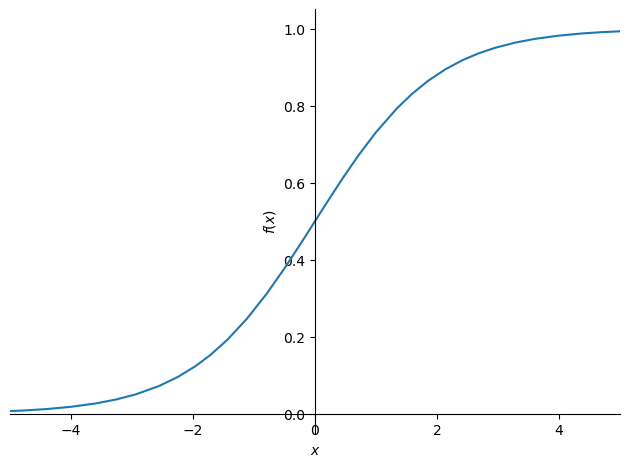

In [49]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [50]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [51]:
coeffs = train_model(30,0.2)

0.510; 0.506; 0.497; 0.485; 0.468; 0.448; 0.426; 0.403; 0.382; 0.363; 0.347; 0.333; 0.323; 0.314; 0.307; 0.300; 0.293; 0.287; 0.280; 0.274; 0.267; 0.261; 0.254; 0.248; 0.242; 0.236; 0.231; 0.227; 0.223; 0.219; 

In [52]:
acc(coeffs)

tensor(0.8315)

In [53]:
show_coeffs()

{'Age': tensor(-1.1115, grad_fn=<UnbindBackward0>),
 'SibSp': tensor(-0.0437, grad_fn=<UnbindBackward0>),
 'Parch': tensor(0.2906, grad_fn=<UnbindBackward0>),
 'Logfare': tensor(-0.0867, grad_fn=<UnbindBackward0>),
 'Sex_male': tensor(-5.2943, grad_fn=<UnbindBackward0>),
 'Sex_female': tensor(3.3101, grad_fn=<UnbindBackward0>),
 'Pclass_1': tensor(1.9618, grad_fn=<UnbindBackward0>),
 'Pclass_2': tensor(0.7249, grad_fn=<UnbindBackward0>),
 'Pclass_3': tensor(-3.0119, grad_fn=<UnbindBackward0>),
 'Embarked_C': tensor(0.2366, grad_fn=<UnbindBackward0>),
 'Embarked_Q': tensor(0.1023, grad_fn=<UnbindBackward0>),
 'Embarked_S': tensor(-1.6115, grad_fn=<UnbindBackward0>)}

# Submitting results to Kaggle

In [54]:
test_df = pd.read_csv(path/"test.csv")
test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [55]:
#Performing the same data cleaning operations on the test_df
test_df['Fare'] = test_df.Fare.fillna(0)
test_df.fillna(modes, inplace=True)
test_df['Logfare'] = np.log(test_df.Fare + 1)
test_df = pd.get_dummies( test_df, columns = ['Sex', 'Embarked', 'Pclass'], dtype= 'float')


In [56]:
test_indep = tensor(test_df[indep_cols].values, dtype = torch.float)
vals, indices = test_indep.max(dim=0)
test_indep = test_indep/vals

In [57]:
test_df['Survived'] = (calc_preds(coeffs, test_indep) > 0.5).int()

In [58]:
sub_df = test_df[['PassengerId', 'Survived']]
sub_df.head(-5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
408,1300,1
409,1301,0
410,1302,1
411,1303,1


In [59]:
# sub_df.to_csv('sub.csv', index = False)

In [60]:
# !head sub.csv 

# Matrix Methods

In [61]:
#Matrix multiplication can be done element-wise like so:
(val_indep*coeffs).sum(axis=1)

tensor([  3.7678,  -8.5675,  -8.4323,  -6.4909,  -6.5649,  -6.7017,   0.4906,   1.9978,  -9.9159,   0.2005, -10.3928,  -8.3988,  -9.9651,
          0.0366, -10.4181,  -5.6154,  -5.8933,   2.0788,  -6.7686,  -1.7756, -10.2816,  -5.7682,   4.9441,   1.7898, -10.2246,  -8.5877,
         -1.3190,  -5.8516, -10.1855,   0.0368,   2.2336,  -1.5199, -10.2121, -10.3721,   3.6845,  -1.3144,  -5.6465,   5.1160, -10.2818,
         -1.6966,  -6.4788, -10.2818,  -6.6370,   5.0035, -10.2263,  -1.6924, -10.3353, -10.1919,  -8.5662,  -1.6483,  -3.9152, -10.0271,
        -10.0161, -10.2941,  -6.5761,  -6.6595,  -8.5676, -10.4624, -10.2401, -10.3532,  -3.5594, -10.1884,  -6.1033, -10.2400,   1.7609,
         -5.2480,  -6.5510, -10.5044,  -8.7557,   1.7611, -10.3094,   0.2595,  -6.6456, -10.2839,  -5.3233, -10.1702, -10.2818,  -5.5402,
         -6.4816,  -6.8724,  -6.2086,   5.2252, -10.2677, -10.2805,   1.6949,  -4.6408,  -3.4168,   3.4906,   3.8324,  -6.5371, -10.3935,
        -10.2818,   5.0267,  -8.51

In [62]:
#Or done using a prebuilt torch method
val_indep@coeffs

tensor([  3.7678,  -8.5676,  -8.4323,  -6.4909,  -6.5649,  -6.7017,   0.4906,   1.9978,  -9.9159,   0.2005, -10.3928,  -8.3988,  -9.9651,
          0.0366, -10.4181,  -5.6154,  -5.8933,   2.0788,  -6.7686,  -1.7756, -10.2816,  -5.7682,   4.9441,   1.7898, -10.2246,  -8.5877,
         -1.3190,  -5.8516, -10.1855,   0.0368,   2.2336,  -1.5199, -10.2121, -10.3721,   3.6845,  -1.3144,  -5.6465,   5.1160, -10.2818,
         -1.6966,  -6.4788, -10.2818,  -6.6370,   5.0035, -10.2263,  -1.6924, -10.3353, -10.1919,  -8.5662,  -1.6483,  -3.9152, -10.0271,
        -10.0161, -10.2941,  -6.5761,  -6.6595,  -8.5676, -10.4624, -10.2401, -10.3532,  -3.5594, -10.1884,  -6.1033, -10.2400,   1.7609,
         -5.2480,  -6.5510, -10.5044,  -8.7557,   1.7611, -10.3094,   0.2595,  -6.6456, -10.2839,  -5.3233, -10.1702, -10.2818,  -5.5402,
         -6.4816,  -6.8724,  -6.2086,   5.2252, -10.2677, -10.2805,   1.6949,  -4.6408,  -3.4168,   3.4906,   3.8324,  -6.5371, -10.3935,
        -10.2818,   5.0267,  -8.51

In [63]:
#updating calc_preds to use the new method
def calc_preds(coeffs, t_indep): return torch.sigmoid(t_indep@coeffs)

In [64]:
#updating init coeffs to produce a nx1 matrix instead of a tensor
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [65]:
trn_dep = trn_dep[:, None] #Indexing into a second dimension creates the second dimension required
val_dep = val_dep[:, None]

In [66]:
trn_dep.shape #Now theres a trailing dimension

torch.Size([713, 1])

In [67]:
coeffs = train_model(30,0.2)

0.512; 0.508; 0.500; 0.487; 0.469; 0.449; 0.425; 0.401; 0.377; 0.356; 0.339; 0.325; 0.313; 0.304; 0.297; 0.290; 0.285; 0.279; 0.273; 0.268; 0.262; 0.257; 0.251; 0.246; 0.240; 0.235; 0.230; 0.226; 0.222; 0.219; 

In [68]:
acc(coeffs)

tensor(0.8258)

# A Neural Network 

1. Create hidden layers 

In [69]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5/ n_hidden) #dividing by n_hidden ensures that gradients are roughly what they were before
    # creates 20 values for each row
    layer2 = (torch.rand(n_hidden, 1)-0.3)
    # generating a column vector of survival
    const = torch.rand(1)[0] 
    #creating a constant term
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [70]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1) #recall relu replaces negatives with 0
    res = res@l2 + const
    return torch.sigmoid(res)

In [81]:
def update_coeffs(coeffs, lr):
    for layer in coeffs: layer.sub_(layer.grad*lr)

In [82]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs,lr)
    return coeffs

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [104]:
coeffs = train_model(lr = 2.8)

0.621; 0.621; 0.621; 0.621; 0.621; 0.620; 0.619; 0.615; 0.555; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 

In [105]:
acc(coeffs)

tensor(0.5955)